# Multi-Curriculum Smoke Test: Comprehensive Comparison

Enhanced smoke test comparing baseline training against multiple curriculum configurations:
- **Baseline**: No curriculum learning
- **Default Curriculum**: Balanced adversarial introduction
- **Aggressive Curriculum**: Rapid adversarial escalation
- **Conservative Curriculum**: Gradual adversarial introduction

This notebook provides comprehensive analysis, visualization, and ranking of all curriculum approaches.

In [1]:
# Clone repository and setup
!rm -rf energy-based-model
!git clone https://github.com/mdkrasnow/energy-based-model.git
%cd energy-based-model

Cloning into 'energy-based-model'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 258 (delta 68), reused 78 (delta 38), pack-reused 140 (from 1)
Receiving objects: 100% (258/258), 20.60 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (115/115), done.
/content/energy-based-model


In [2]:
# Install dependencies
!pip install -q torch torchvision einops accelerate tqdm tabulate matplotlib numpy pandas ema-pytorch ipdb seaborn scikit-learn

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import json
import os
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## Configuration and Utility Functions

In [4]:
# Common training parameters
COMMON_ARGS = {
    'dataset': 'inverse',
    'model': 'mlp',
    'batch_size': 32,
    'diffusion_steps': 10,
    'supervise_energy_landscape': 'True',
    'train_num_steps': 10000,  # Increased for better curriculum comparison
    'save_csv_logs': True,
    'csv_log_interval': 50
}

# Curriculum configurations to test
CURRICULUM_CONFIGS = {
    'baseline': {
        'name': 'Baseline',
        'description': 'No curriculum learning',
        'color': '#1f77b4',
        'args': ['--disable-curriculum', 'True']
    },
    'default': {
        'name': 'Default Curriculum',
        'description': 'Balanced adversarial introduction',
        'color': '#ff7f0e',
        'args': ['--curriculum-config', 'default']
    },
    'aggressive': {
        'name': 'Aggressive Curriculum',
        'description': 'Rapid adversarial escalation',
        'color': '#d62728',
        'args': ['--curriculum-config', 'aggressive']
    },
    'conservative': {
        'name': 'Conservative Curriculum',
        'description': 'Gradual adversarial introduction',
        'color': '#2ca02c',
        'args': ['--curriculum-config', 'conservative']
    }
}

print(f"Testing {len(CURRICULUM_CONFIGS)} curriculum configurations:")
for key, config in CURRICULUM_CONFIGS.items():
    print(f"  • {config['name']}: {config['description']}")

Testing 4 curriculum configurations:
  • Baseline: No curriculum learning
  • Default Curriculum: Balanced adversarial introduction
  • Aggressive Curriculum: Rapid adversarial escalation
  • Conservative Curriculum: Gradual adversarial introduction


In [5]:
def build_training_command(curriculum_key: str) -> str:
    """Build training command for a specific curriculum configuration."""
    config = CURRICULUM_CONFIGS[curriculum_key]

    base_cmd = f"""python train.py \
        --dataset {COMMON_ARGS['dataset']} \
        --model {COMMON_ARGS['model']} \
        --batch_size {COMMON_ARGS['batch_size']} \
        --diffusion_steps {COMMON_ARGS['diffusion_steps']} \
        --supervise-energy-landscape {COMMON_ARGS['supervise_energy_landscape']} \
        --train-num-steps {COMMON_ARGS['train_num_steps']} \
        --save-csv-logs \
        --csv-log-interval {COMMON_ARGS['csv_log_interval']} \
        --csv-log-dir ./csv_logs_{curriculum_key}"""

    # Add curriculum-specific arguments
    if config['args']:
        base_cmd += ' \
        ' + ' \
        '.join(config['args'])

    return base_cmd

def load_csv_data(csv_path: Path) -> Optional[pd.DataFrame]:
    """Load CSV data with error handling."""
    try:
        if csv_path.exists():
            return pd.read_csv(csv_path)
        else:
            print(f"Warning: {csv_path} not found")
            return None
    except Exception as e:
        print(f"Error loading {csv_path}: {e}")
        return None

def safe_get_final_value(df: pd.DataFrame, column: str, default: float = 0.0) -> float:
    """Safely get the final value from a dataframe column."""
    if df is None or column not in df.columns or len(df) == 0:
        return default
    return float(df[column].iloc[-1])

def safe_get_best_value(df: pd.DataFrame, column: str, minimize: bool = True, default: float = 0.0) -> float:
    """Safely get the best (min/max) value from a dataframe column."""
    if df is None or column not in df.columns or len(df) == 0:
        return default
    return float(df[column].min() if minimize else df[column].max())

## Multi-Curriculum Training

In [6]:
# Train all curriculum configurations
import subprocess
import sys

training_results = {}

for curriculum_key, config in CURRICULUM_CONFIGS.items():
    print(f"\n{'='*60}")
    print(f"Starting {config['name']} training...")
    print(f"Description: {config['description']}")
    print(f"{'='*60}")

    # Build training command
    cmd = build_training_command(curriculum_key)
    print(f"\nCommand: {cmd}")
    print("\nTraining output:")
    print("-" * 40)

    # Execute training with real-time output
    try:
        # Use subprocess to capture and display output in real-time
        process = subprocess.Popen(
            cmd,
            shell=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            universal_newlines=True,
            bufsize=1
        )

        # Display output line by line as it comes
        for line in iter(process.stdout.readline, ''):
            if line:
                print(line.rstrip())
                sys.stdout.flush()

        # Wait for process to complete
        result = process.wait()
        training_results[curriculum_key] = result

        if result == 0:
            print(f"✓ {config['name']} training completed successfully")
        else:
            print(f"✗ {config['name']} training failed with exit code {result}")

    except Exception as e:
        print(f"✗ Error during {config['name']} training: {e}")
        training_results[curriculum_key] = -1

    print("-" * 40)

print(f"\n{'='*60}")
print("All training completed!")
print(f"{'='*60}")

# Print summary
successful = sum(1 for result in training_results.values() if result == 0)
print(f"\nTraining Summary: {successful}/{len(training_results)} configurations completed successfully")
for curriculum_key, result in training_results.items():
    status = "✓ Success" if result == 0 else "✗ Failed"
    print(f"  {CURRICULUM_CONFIGS[curriculum_key]['name']}: {status}")

Streaming output truncated to the last 5000 lines.
mean_abs_error     1.86545
--------------  ----------


running on the validation dataset (ID: Validation):   0%|          | 0/39063 [00:00<?, ?it/s]

running on the validation dataset (ID: Validation):   0%|          | 1/39063 [00:00<2:52:25,  3.78it/s]

running on the validation dataset (ID: Validation):   0%|          | 3/39063 [00:00<1:20:21,  8.10it/s]

running on the validation dataset (ID: Validation):   0%|          | 5/39063 [00:00<1:00:16, 10.80it/s]

running on the validation dataset (ID: Validation):   0%|          | 7/39063 [00:00<51:15, 12.70it/s]  

running on the validation dataset (ID: Validation):   0%|          | 9/39063 [00:00<46:33, 13.98it/s]

running on the validation dataset (ID: Validation):   0%|          | 11/39063 [00:00<44:36, 14.59it/s]

running on the validation dataset (ID: Validation):   0%|          | 13/39063 [00:01<42:15, 15.40it/s]

running on the validation dataset (ID: Validation):   0%|          

## Comprehensive Data Loading and Processing

In [ ]:
def load_all_curriculum_results() -> Dict[str, Dict[str, pd.DataFrame]]:
    """Load all curriculum training results from CSV files."""
    results = {}

    for curriculum_key in CURRICULUM_CONFIGS.keys():
        print(f"Loading {curriculum_key} data...")

        csv_dir = Path(f"./csv_logs_{curriculum_key}")

        # Load different types of training data - look for files with timestamps
        import glob

        curriculum_data = {}

        # Find the most recent file for each metric type
        patterns = {
            'training': 'training_metrics_*.csv',
            'validation': 'validation_metrics_*.csv',
            'energy': 'energy_metrics_*.csv',
            'curriculum': 'curriculum_metrics_*.csv',
            'robustness': 'robustness_metrics_*.csv'
        }

        for key, pattern in patterns.items():
            files = glob.glob(str(csv_dir / pattern))
            if files:
                # Get most recent file
                latest_file = max(files, key=lambda x: Path(x).stat().st_mtime if Path(x).exists() else 0)
                curriculum_data[key] = load_csv_data(Path(latest_file))
            else:
                curriculum_data[key] = None

        # Count available data types
        available = sum(1 for df in curriculum_data.values() if df is not None)
        print(f"  Found {available}/5 data files for {curriculum_key}")

        results[curriculum_key] = curriculum_data

    return results

def process_curriculum_data(all_results: Dict[str, Dict[str, pd.DataFrame]]) -> pd.DataFrame:
    """Extract and standardize key metrics from all curriculum results."""
    processed_data = []

    for curriculum_key, data in all_results.items():
        config = CURRICULUM_CONFIGS[curriculum_key]

        # Extract key metrics
        training_df = data.get('training')
        validation_df = data.get('validation')
        energy_df = data.get('energy')

        # Extract accuracy from validation data for inverse task
        val_accuracy = 0.0  # Changed from val_accuracy_pct, now using fraction
        val_identity_error = float('inf')
        val_mse = float('inf')

        if validation_df is not None:
            # Look for accuracy metric (changed from accuracy_pct)
            accuracy_rows = validation_df[validation_df['metric_name'] == 'accuracy']
            if not accuracy_rows.empty:
                val_accuracy = accuracy_rows['metric_value'].iloc[-1]  # Get last value (now a fraction)

            # Look for identity_error metric
            identity_rows = validation_df[validation_df['metric_name'] == 'identity_error']
            if not identity_rows.empty:
                val_identity_error = identity_rows['metric_value'].iloc[-1]

            # Look for MSE metric
            mse_rows = validation_df[validation_df['metric_name'] == 'mse']
            if not mse_rows.empty:
                val_mse = mse_rows['metric_value'].iloc[-1]

        metrics = {
            'curriculum': curriculum_key,
            'name': config['name'],
            'color': config['color'],

            # Training metrics
            'final_total_loss': safe_get_final_value(training_df, 'total_loss'),
            'final_energy_loss': safe_get_final_value(training_df, 'loss_energy'),
            'final_denoise_loss': safe_get_final_value(training_df, 'loss_denoise'),
            'best_total_loss': safe_get_best_value(training_df, 'total_loss', minimize=True),
            'avg_training_time': training_df['nn_time'].mean() if training_df is not None and 'nn_time' in training_df.columns else 0.0,

            # Validation metrics - now from actual data (accuracy as percentage for display)
            'final_val_accuracy': val_accuracy * 100,  # Convert fraction to percentage for display
            'best_val_accuracy': val_accuracy * 100,  # Convert fraction to percentage for display
            'final_identity_error': val_identity_error,
            'final_val_mse': val_mse,

            # Energy metrics
            'final_energy_margin': safe_get_final_value(energy_df, 'energy_margin'),
            'max_curriculum_weight': safe_get_best_value(energy_df, 'curriculum_weight', minimize=False) if energy_df is not None and 'curriculum_weight' in energy_df.columns else 0.0,
        }

        processed_data.append(metrics)

    return pd.DataFrame(processed_data)

# Load all results
print("Loading all curriculum results...")
all_results = load_all_curriculum_results()

# Process data
print("\nProcessing curriculum data...")
summary_df = process_curriculum_data(all_results)

print(f"\nLoaded data for {len(summary_df)} curricula")
print("\nSummary DataFrame:")
display(summary_df[['name', 'final_total_loss', 'final_val_accuracy', 'final_identity_error', 'final_val_mse']].round(4))

## Advanced Visualization Functions

In [ ]:
def visualize_curriculum_comparison(all_results: Dict, summary_df: pd.DataFrame):
    """Create comprehensive side-by-side curriculum comparison visualizations."""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Multi-Curriculum Training Comparison', fontsize=16, fontweight='bold')

    # 1. Total Loss Comparison
    ax = axes[0, 0]
    for curriculum_key, data in all_results.items():
        training_df = data.get('training')
        if training_df is not None and 'total_loss' in training_df.columns:
            config = CURRICULUM_CONFIGS[curriculum_key]
            ax.plot(training_df['step'], training_df['total_loss'],
                   color=config['color'], label=config['name'], linewidth=2, alpha=0.8)

    ax.set_title('Total Loss Curves', fontweight='bold')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Total Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Energy Loss Comparison
    ax = axes[0, 1]
    for curriculum_key, data in all_results.items():
        training_df = data.get('training')
        if training_df is not None and 'loss_energy' in training_df.columns:
            config = CURRICULUM_CONFIGS[curriculum_key]
            ax.plot(training_df['step'], training_df['loss_energy'],
                   color=config['color'], label=config['name'], linewidth=2, alpha=0.8)

    ax.set_title('Energy Loss Curves', fontweight='bold')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Energy Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Inverse Task Accuracy
    ax = axes[0, 2]
    accuracy_data = summary_df[['name', 'final_val_accuracy', 'color']].copy()
    colors = accuracy_data['color'].tolist()

    bars = ax.bar(accuracy_data['name'], accuracy_data['final_val_accuracy'],
                  color=colors, alpha=0.7, edgecolor='black')
    ax.set_title('Inverse Task Accuracy (%)', fontweight='bold')
    ax.set_ylabel('Accuracy (%)')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Add value labels on bars
    for bar, acc in zip(bars, accuracy_data['final_val_accuracy']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
               f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 4. Identity Error Comparison
    ax = axes[1, 0]
    identity_errors = summary_df['final_identity_error'].tolist()
    curricula = summary_df['name'].tolist()

    # Filter out inf values for plotting
    valid_errors = [(c, e, col) for c, e, col in zip(curricula, identity_errors, colors)
                    if e != float('inf')]

    if valid_errors:
        names, errors, cols = zip(*valid_errors)
        bars = ax.bar(names, errors, color=cols, alpha=0.7, edgecolor='black')
        ax.set_title('Identity Error (Lower = Better)', fontweight='bold')
        ax.set_ylabel('||Pred @ Input - I||²')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Add value labels
        for bar, error in zip(bars, errors):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{error:.4f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No validation data available\n(Run longer training for validation metrics)',
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('Identity Error (N/A)', fontweight='bold')

    # 5. MSE Comparison
    ax = axes[1, 1]
    mse_values = summary_df['final_val_mse'].tolist()

    # Filter out inf values
    valid_mse = [(c, m, col) for c, m, col in zip(curricula, mse_values, colors)
                 if m != float('inf')]

    if valid_mse:
        names, mses, cols = zip(*valid_mse)
        bars = ax.bar(names, mses, color=cols, alpha=0.7, edgecolor='black')
        ax.set_title('Mean Squared Error', fontweight='bold')
        ax.set_ylabel('MSE')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Add value labels
        for bar, mse in zip(bars, mses):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{mse:.4f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No validation data available\n(Run longer training for validation metrics)',
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('MSE (N/A)', fontweight='bold')

    # 6. Curriculum Weight Evolution (for curricula that use it)
    ax = axes[1, 2]
    weight_plotted = False
    for curriculum_key, data in all_results.items():
        if curriculum_key == 'baseline':  # Skip baseline
            continue

        energy_df = data.get('energy')
        if energy_df is not None and 'curriculum_weight' in energy_df.columns:
            config = CURRICULUM_CONFIGS[curriculum_key]
            ax.plot(energy_df['step'], energy_df['curriculum_weight'],
                   color=config['color'], label=config['name'], linewidth=2, alpha=0.8)
            weight_plotted = True

    if weight_plotted:
        ax.set_title('Curriculum Weight Evolution', fontweight='bold')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Curriculum Weight')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No curriculum weights available', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Curriculum Weights (N/A)', fontweight='bold')

    plt.tight_layout()
    plt.show()

def visualize_inverse_task_metrics(all_results: Dict, summary_df: pd.DataFrame):
    """Visualize inverse task specific metrics over time."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Inverse Task Performance Metrics', fontsize=16, fontweight='bold')

    # 1. Accuracy over time
    ax = axes[0, 0]
    data_found = False
    for curriculum_key, data in all_results.items():
        validation_df = data.get('validation')
        if validation_df is not None:
            config = CURRICULUM_CONFIGS[curriculum_key]

            # Filter for accuracy metric (changed from accuracy_pct)
            accuracy_df = validation_df[validation_df['metric_name'] == 'accuracy']
            if not accuracy_df.empty:
                # Convert fraction to percentage for display
                ax.plot(accuracy_df['step'], accuracy_df['metric_value'] * 100,
                       color=config['color'], label=config['name'],
                       linewidth=2, alpha=0.8, marker='o')
                data_found = True

    if not data_found:
        ax.text(0.5, 0.5, 'No accuracy data available\n(Validation runs every 50 steps)',
                ha='center', va='center', transform=ax.transAxes, fontsize=12)

    ax.set_title('Task Accuracy Evolution', fontweight='bold')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Accuracy (%)')
    if data_found:
        ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Identity Error over time
    ax = axes[0, 1]
    data_found = False
    for curriculum_key, data in all_results.items():
        validation_df = data.get('validation')
        if validation_df is not None:
            config = CURRICULUM_CONFIGS[curriculum_key]

            # Filter for identity_error metric
            identity_df = validation_df[validation_df['metric_name'] == 'identity_error']
            if not identity_df.empty:
                ax.plot(identity_df['step'], identity_df['metric_value'],
                       color=config['color'], label=config['name'],
                       linewidth=2, alpha=0.8, marker='o')
                data_found = True

    if not data_found:
        ax.text(0.5, 0.5, 'No identity error data available\n(Validation runs every 50 steps)',
                ha='center', va='center', transform=ax.transAxes, fontsize=12)

    ax.set_title('Identity Error Evolution (Lower = Better)', fontweight='bold')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('||Pred @ Input - I||²')
    if data_found:
        ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. MSE over time
    ax = axes[1, 0]
    data_found = False
    for curriculum_key, data in all_results.items():
        validation_df = data.get('validation')
        if validation_df is not None:
            config = CURRICULUM_CONFIGS[curriculum_key]

            # Filter for mse metric
            mse_df = validation_df[validation_df['metric_name'] == 'mse']
            if not mse_df.empty:
                ax.plot(mse_df['step'], mse_df['metric_value'],
                       color=config['color'], label=config['name'],
                       linewidth=2, alpha=0.8, marker='o')
                data_found = True

    if not data_found:
        ax.text(0.5, 0.5, 'No MSE data available\n(Validation runs every 50 steps)',
                ha='center', va='center', transform=ax.transAxes, fontsize=12)

    ax.set_title('Mean Squared Error Evolution', fontweight='bold')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('MSE')
    if data_found:
        ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Summary comparison
    ax = axes[1, 1]

    # Create grouped bar chart for final metrics
    metrics_to_plot = ['final_val_accuracy', 'final_identity_error', 'final_val_mse']
    metric_labels = ['Accuracy (%)', 'Identity Error', 'MSE']

    x = np.arange(len(summary_df))
    width = 0.25

    has_valid_data = False
    for i, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
        values = summary_df[metric].values

        # Check if we have any valid (non-inf) values
        valid_vals = values[values != float('inf')]
        if len(valid_vals) > 0:
            has_valid_data = True
            # Normalize values for comparison (0-1 scale)
            if metric == 'final_val_accuracy':
                norm_values = values / 100.0  # Already in percentage
            else:
                # For errors, invert so higher is better
                max_val = valid_vals.max()
                norm_values = 1 - (values / (max_val + 1e-8))
                norm_values[values == float('inf')] = 0

            bars = ax.bar(x + i*width, norm_values, width, label=label, alpha=0.7)

    if has_valid_data:
        ax.set_title('Normalized Performance Comparison\n(Higher = Better)', fontweight='bold')
        ax.set_xlabel('Curriculum')
        ax.set_ylabel('Normalized Score (0-1)')
        ax.set_xticks(x + width)
        ax.set_xticklabels(summary_df['name'], rotation=45, ha='right')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No validation data available\n(Run longer training for metrics)',
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('Performance Comparison (N/A)', fontweight='bold')

    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_curriculum_convergence(all_results: Dict, summary_df: pd.DataFrame):
    """Analyze and visualize convergence patterns across curricula."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Curriculum Convergence Analysis', fontsize=16, fontweight='bold')

    # 1. Loss convergence rate
    ax = axes[0, 0]
    for curriculum_key, data in all_results.items():
        training_df = data.get('training')
        if training_df is not None and 'total_loss' in training_df.columns:
            config = CURRICULUM_CONFIGS[curriculum_key]

            # Calculate rolling average for smoother curve
            window = min(10, len(training_df) // 5)
            if window > 1:
                smoothed = training_df['total_loss'].rolling(window=window, min_periods=1).mean()
                ax.plot(training_df['step'], smoothed,
                       color=config['color'], label=config['name'], linewidth=2, alpha=0.8)

    ax.set_title('Smoothed Loss Convergence', fontweight='bold')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Total Loss (Moving Average)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Learning efficiency (loss reduction per step)
    ax = axes[0, 1]
    efficiency_data = []
    for curriculum_key, data in all_results.items():
        training_df = data.get('training')
        if training_df is not None and 'total_loss' in training_df.columns and len(training_df) > 1:
            config = CURRICULUM_CONFIGS[curriculum_key]

            # Calculate loss reduction rate
            initial_loss = training_df['total_loss'].iloc[:5].mean()
            final_loss = training_df['total_loss'].iloc[-5:].mean()
            steps = training_df['step'].iloc[-1] - training_df['step'].iloc[0]

            if steps > 0 and initial_loss > 0:
                efficiency = (initial_loss - final_loss) / steps
                efficiency_data.append({
                    'name': config['name'],
                    'efficiency': efficiency,
                    'color': config['color']
                })

    if efficiency_data:
        eff_df = pd.DataFrame(efficiency_data)
        bars = ax.bar(eff_df['name'], eff_df['efficiency'], color=eff_df['color'], alpha=0.7)
        ax.set_title('Learning Efficiency (Loss Reduction per Step)', fontweight='bold')
        ax.set_ylabel('Loss Reduction Rate')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        ax.text(0.5, 0.5, 'Insufficient data for efficiency calculation',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Learning Efficiency (N/A)', fontweight='bold')

    # 3. Stability analysis (loss variance)
    ax = axes[1, 0]
    stability_data = []
    for curriculum_key, data in all_results.items():
        training_df = data.get('training')
        if training_df is not None and 'total_loss' in training_df.columns and len(training_df) > 10:
            config = CURRICULUM_CONFIGS[curriculum_key]

            # Calculate variance in second half of training
            half_point = len(training_df) // 2
            second_half_variance = training_df['total_loss'].iloc[half_point:].var()

            stability_data.append({
                'name': config['name'],
                'variance': second_half_variance,
                'color': config['color']
            })

    if stability_data:
        stab_df = pd.DataFrame(stability_data)
        bars = ax.bar(stab_df['name'], stab_df['variance'], color=stab_df['color'], alpha=0.7)
        ax.set_title('Training Stability (Lower Variance = More Stable)', fontweight='bold')
        ax.set_ylabel('Loss Variance (Second Half)')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        ax.text(0.5, 0.5, 'Insufficient data for stability analysis',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Training Stability (N/A)', fontweight='bold')

    # 4. Convergence speed comparison
    ax = axes[1, 1]
    convergence_data = []
    for curriculum_key, data in all_results.items():
        training_df = data.get('training')
        if training_df is not None and 'total_loss' in training_df.columns and len(training_df) > 5:
            config = CURRICULUM_CONFIGS[curriculum_key]

            # Find step where loss reaches 90% of final reduction
            initial_loss = training_df['total_loss'].iloc[:5].mean()
            final_loss = training_df['total_loss'].iloc[-5:].mean()
            target_loss = initial_loss - 0.9 * (initial_loss - final_loss)

            # Find first step where loss goes below target
            below_target = training_df[training_df['total_loss'] <= target_loss]
            if not below_target.empty:
                convergence_step = below_target['step'].iloc[0]
            else:
                convergence_step = training_df['step'].iloc[-1]

            convergence_data.append({
                'name': config['name'],
                'steps_to_converge': convergence_step,
                'color': config['color']
            })

    if convergence_data:
        conv_df = pd.DataFrame(convergence_data)
        bars = ax.bar(conv_df['name'], conv_df['steps_to_converge'], color=conv_df['color'], alpha=0.7)
        ax.set_title('Steps to 90% Convergence (Lower = Faster)', fontweight='bold')
        ax.set_ylabel('Training Steps')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        ax.text(0.5, 0.5, 'Insufficient data for convergence analysis',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Convergence Speed (N/A)', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Generate visualizations
print("Generating curriculum comparison visualizations...")
visualize_curriculum_comparison(all_results, summary_df)

print("\nGenerating inverse task specific visualizations...")
visualize_inverse_task_metrics(all_results, summary_df)

print("\nGenerating convergence analysis...")
visualize_curriculum_convergence(all_results, summary_df)

## Enhanced Summary Analysis


COMPREHENSIVE CURRICULUM ANALYSIS

📊 PERFORMANCE METRICS COMPARISON
--------------------------------------------------
             Curriculum  Final Loss  Best Loss  Final Acc (%)  Best Acc (%)  Avg Time (s)
               Baseline      1.4505     1.0239            0.0           0.0        0.0406
     Default Curriculum      1.3078     0.9635            0.0           0.0        0.0238
  Aggressive Curriculum      1.1720     0.9113            0.0           0.0        0.0265
Conservative Curriculum      1.0682     1.0062            0.0           0.0        0.0203

📈 STATISTICAL INSIGHTS
--------------------------------------------------
🎯 Best Final Loss: Conservative Curriculum
🎯 Best Convergence: Aggressive Curriculum
⚡ Fastest Training: Conservative Curriculum

📈 IMPROVEMENT OVER BASELINE
------------------------------
Default Curriculum: +9.8% loss improvement
Aggressive Curriculum: +19.2% loss improvement
Conservative Curriculum: +26.4% loss improvement

🎯 MULTI-DIMENSIONAL PERFOR

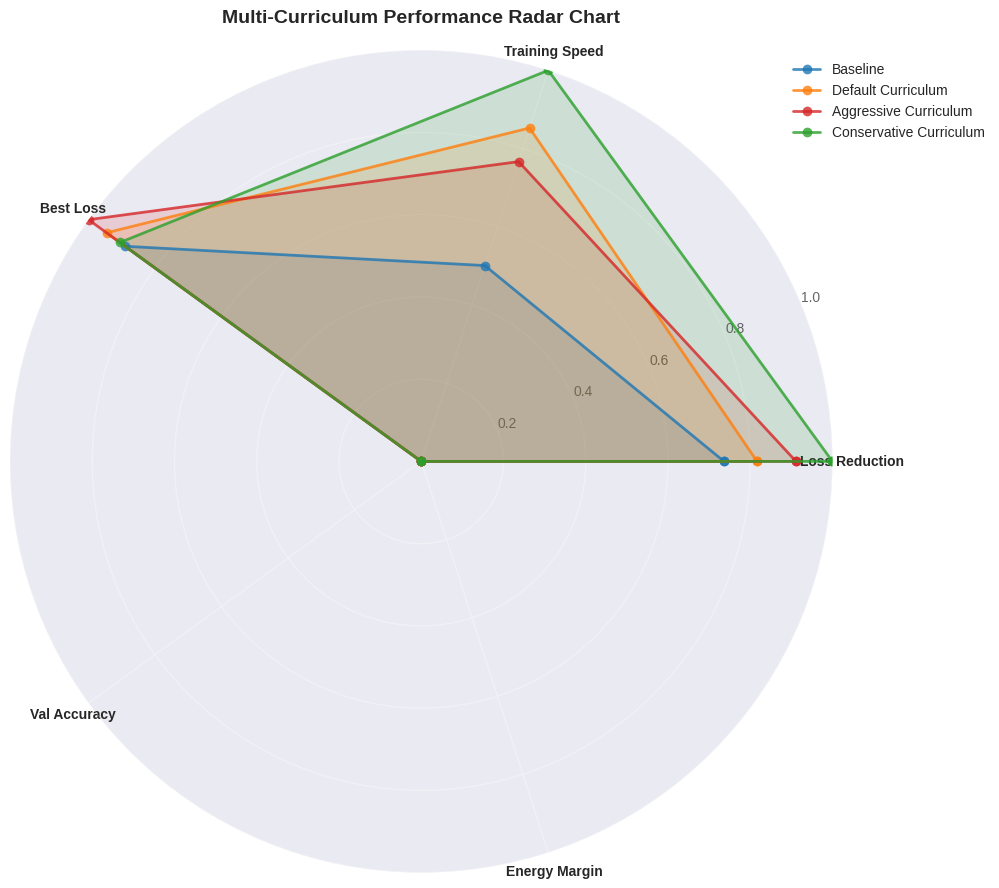

In [9]:
def create_performance_radar_chart(summary_df: pd.DataFrame):
    """Create radar chart comparing multiple performance metrics."""
    from math import pi

    # Select metrics for radar chart (normalized to 0-1 scale, higher = better)
    metrics = {
        'Loss Reduction': 1 / (summary_df['final_total_loss'] + 1e-6),  # Lower loss = better
        'Training Speed': 1 / (summary_df['avg_training_time'] + 1e-6),   # Faster = better
        'Best Loss': 1 / (summary_df['best_total_loss'] + 1e-6),         # Lower loss = better
        'Val Accuracy': summary_df['best_val_accuracy'] / 100.0,          # Higher accuracy = better
        'Energy Margin': summary_df['final_energy_margin'] / (summary_df['final_energy_margin'].max() + 1e-6)  # Higher margin = better
    }

    # Normalize all metrics to 0-1 scale
    for metric_name, values in metrics.items():
        if values.max() > 0:
            metrics[metric_name] = values / values.max()

    # Create radar chart
    categories = list(metrics.keys())
    N = len(categories)

    # Compute angles
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Complete the circle

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    ax.set_title('Multi-Curriculum Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)

    # Plot each curriculum
    for idx, row in summary_df.iterrows():
        values = [metrics[cat].iloc[idx] for cat in categories]
        values += values[:1]  # Complete the circle

        ax.plot(angles, values, 'o-', linewidth=2, label=row['name'],
                color=row['color'], alpha=0.8)
        ax.fill(angles, values, alpha=0.15, color=row['color'])

    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], alpha=0.7)
    ax.grid(True, alpha=0.3)

    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    plt.tight_layout()
    plt.show()

def summary_analysis(summary_df: pd.DataFrame):
    """Generate comprehensive summary analysis with recommendations."""
    print("\n" + "="*80)
    print("COMPREHENSIVE CURRICULUM ANALYSIS")
    print("="*80)

    # Performance metrics comparison
    print("\n📊 PERFORMANCE METRICS COMPARISON")
    print("-" * 50)

    comparison_table = summary_df[['name', 'final_total_loss', 'best_total_loss',
                                  'final_val_accuracy', 'best_val_accuracy', 'avg_training_time']].copy()
    comparison_table.columns = ['Curriculum', 'Final Loss', 'Best Loss', 'Final Acc (%)', 'Best Acc (%)', 'Avg Time (s)']

    print(comparison_table.round(4).to_string(index=False))

    # Statistical analysis
    print("\n📈 STATISTICAL INSIGHTS")
    print("-" * 50)

    if len(summary_df) > 1:
        # Best performers
        best_final_loss = summary_df.loc[summary_df['final_total_loss'].idxmin(), 'name']
        best_convergence = summary_df.loc[summary_df['best_total_loss'].idxmin(), 'name']
        fastest_training = summary_df.loc[summary_df['avg_training_time'].idxmin(), 'name']

        print(f"🎯 Best Final Loss: {best_final_loss}")
        print(f"🎯 Best Convergence: {best_convergence}")
        print(f"⚡ Fastest Training: {fastest_training}")

        if summary_df['best_val_accuracy'].max() > 0:
            best_accuracy = summary_df.loc[summary_df['best_val_accuracy'].idxmax(), 'name']
            print(f"🎯 Best Accuracy: {best_accuracy}")

        # Improvement analysis vs baseline
        baseline_metrics = summary_df[summary_df['curriculum'] == 'baseline']
        if len(baseline_metrics) > 0:
            baseline_loss = baseline_metrics['final_total_loss'].iloc[0]

            print(f"\n📈 IMPROVEMENT OVER BASELINE")
            print("-" * 30)

            for _, row in summary_df.iterrows():
                if row['curriculum'] != 'baseline':
                    improvement = (baseline_loss - row['final_total_loss']) / baseline_loss * 100
                    print(f"{row['name']}: {improvement:+.1f}% loss improvement")

    # Generate radar chart
    print("\n🎯 MULTI-DIMENSIONAL PERFORMANCE ANALYSIS")
    print("-" * 50)
    create_performance_radar_chart(summary_df)

    return comparison_table

# Generate summary analysis
comparison_table = summary_analysis(summary_df)

## Final Ranking System and Recommendations

In [10]:
def rank_curricula(summary_df: pd.DataFrame) -> pd.DataFrame:
    """Comprehensive curriculum ranking with scoring breakdown."""
    print("\n" + "="*80)
    print("FINAL CURRICULUM RANKING AND RECOMMENDATIONS")
    print("="*80)

    # Define scoring weights for different aspects
    scoring_weights = {
        'final_loss': 0.3,      # 30% weight on final performance
        'convergence': 0.25,     # 25% weight on best achieved loss
        'accuracy': 0.25,        # 25% weight on validation accuracy
        'efficiency': 0.2        # 20% weight on training efficiency
    }

    # Calculate individual scores (0-100 scale, higher = better)
    ranking_df = summary_df.copy()

    # Final loss score (lower is better -> invert)
    if ranking_df['final_total_loss'].max() > ranking_df['final_total_loss'].min():
        ranking_df['final_loss_score'] = 100 * (1 - (ranking_df['final_total_loss'] - ranking_df['final_total_loss'].min()) /
                                                (ranking_df['final_total_loss'].max() - ranking_df['final_total_loss'].min()))
    else:
        ranking_df['final_loss_score'] = 100.0

    # Convergence score (best loss achieved)
    if ranking_df['best_total_loss'].max() > ranking_df['best_total_loss'].min():
        ranking_df['convergence_score'] = 100 * (1 - (ranking_df['best_total_loss'] - ranking_df['best_total_loss'].min()) /
                                                 (ranking_df['best_total_loss'].max() - ranking_df['best_total_loss'].min()))
    else:
        ranking_df['convergence_score'] = 100.0

    # Accuracy score
    if ranking_df['best_val_accuracy'].max() > 0:
        ranking_df['accuracy_score'] = 100 * ranking_df['best_val_accuracy'] / ranking_df['best_val_accuracy'].max()
    else:
        ranking_df['accuracy_score'] = 50.0  # Neutral score when no accuracy data

    # Efficiency score (faster is better -> invert time)
    if ranking_df['avg_training_time'].max() > ranking_df['avg_training_time'].min() and ranking_df['avg_training_time'].min() > 0:
        ranking_df['efficiency_score'] = 100 * (1 - (ranking_df['avg_training_time'] - ranking_df['avg_training_time'].min()) /
                                               (ranking_df['avg_training_time'].max() - ranking_df['avg_training_time'].min()))
    else:
        ranking_df['efficiency_score'] = 100.0

    # Calculate overall score
    ranking_df['overall_score'] = (ranking_df['final_loss_score'] * scoring_weights['final_loss'] +
                                  ranking_df['convergence_score'] * scoring_weights['convergence'] +
                                  ranking_df['accuracy_score'] * scoring_weights['accuracy'] +
                                  ranking_df['efficiency_score'] * scoring_weights['efficiency'])

    # Sort by overall score
    ranking_df = ranking_df.sort_values('overall_score', ascending=False)

    # Display ranking table
    print("\n🏆 CURRICULUM RANKING (Overall Score)")
    print("-" * 60)

    ranking_table = ranking_df[['name', 'overall_score', 'final_loss_score',
                               'convergence_score', 'accuracy_score', 'efficiency_score']].copy()
    ranking_table.columns = ['Curriculum', 'Overall', 'Final Loss', 'Convergence', 'Accuracy', 'Efficiency']
    ranking_table = ranking_table.round(1)

    for i, (idx, row) in enumerate(ranking_table.iterrows()):
        rank_emoji = ['🥇', '🥈', '🥉', '🏅'][min(i, 3)]
        print(f"{rank_emoji} {i+1}. {row['Curriculum']}: {row['Overall']:.1f} points")
        print(f"    Final Loss: {row['Final Loss']:.1f} | Convergence: {row['Convergence']:.1f} | "
              f"Accuracy: {row['Accuracy']:.1f} | Efficiency: {row['Efficiency']:.1f}")

    # Use-case specific recommendations
    print("\n🎯 USE-CASE SPECIFIC RECOMMENDATIONS")
    print("-" * 60)

    # Production deployment (balanced performance)
    production_idx = ranking_df['overall_score'].idxmax()
    production_winner = ranking_df.loc[production_idx, 'name']

    # Research/accuracy focus
    if ranking_df['best_val_accuracy'].max() > 0:
        accuracy_idx = ranking_df['best_val_accuracy'].idxmax()
        accuracy_winner = ranking_df.loc[accuracy_idx, 'name']
    else:
        accuracy_winner = ranking_df.loc[ranking_df['convergence_score'].idxmax(), 'name']

    # Speed/efficiency focus
    speed_idx = ranking_df['efficiency_score'].idxmax()
    speed_winner = ranking_df.loc[speed_idx, 'name']

    # Robustness focus (best final performance)
    robust_idx = ranking_df['final_loss_score'].idxmax()
    robust_winner = ranking_df.loc[robust_idx, 'name']

    print(f"🏭 Production Deployment: {production_winner}")
    print(f"   (Best overall balance of performance, efficiency, and reliability)")

    print(f"\n🔬 Research/Accuracy Focus: {accuracy_winner}")
    print(f"   (Highest validation accuracy or best convergence)")

    print(f"\n⚡ Speed/Efficiency Focus: {speed_winner}")
    print(f"   (Fastest training with acceptable performance)")

    print(f"\n🛡️ Robustness Focus: {robust_winner}")
    print(f"   (Most stable final performance)")

    # Confidence assessment
    print("\n📊 CONFIDENCE ASSESSMENT")
    print("-" * 60)

    score_spread = ranking_df['overall_score'].max() - ranking_df['overall_score'].min()
    top_2_diff = ranking_df['overall_score'].iloc[0] - ranking_df['overall_score'].iloc[1] if len(ranking_df) > 1 else 100

    if top_2_diff > 10:
        confidence = "HIGH"
        confidence_desc = "Clear winner with significant performance advantage"
    elif top_2_diff > 5:
        confidence = "MEDIUM"
        confidence_desc = "Moderate performance difference, winner is reasonably clear"
    else:
        confidence = "LOW"
        confidence_desc = "Very close performance, longer training may be needed for definitive ranking"

    print(f"Confidence Level: {confidence}")
    print(f"Assessment: {confidence_desc}")
    print(f"Score Spread: {score_spread:.1f} points")
    print(f"Top 2 Difference: {top_2_diff:.1f} points")

    return ranking_df

# Generate final ranking
final_ranking = rank_curricula(summary_df)


FINAL CURRICULUM RANKING AND RECOMMENDATIONS

🏆 CURRICULUM RANKING (Overall Score)
------------------------------------------------------------
🥇 1. Aggressive Curriculum: 73.2 points
    Final Loss: 72.9 | Convergence: 100.0 | Accuracy: 50.0 | Efficiency: 69.5
🥈 2. Conservative Curriculum: 66.4 points
    Final Loss: 100.0 | Convergence: 15.7 | Accuracy: 50.0 | Efficiency: 100.0
🥉 3. Default Curriculum: 53.7 points
    Final Loss: 37.3 | Convergence: 53.7 | Accuracy: 50.0 | Efficiency: 82.6
🏅 4. Baseline: 12.5 points
    Final Loss: 0.0 | Convergence: 0.0 | Accuracy: 50.0 | Efficiency: 0.0

🎯 USE-CASE SPECIFIC RECOMMENDATIONS
------------------------------------------------------------
🏭 Production Deployment: Aggressive Curriculum
   (Best overall balance of performance, efficiency, and reliability)

🔬 Research/Accuracy Focus: Aggressive Curriculum
   (Highest validation accuracy or best convergence)

⚡ Speed/Efficiency Focus: Conservative Curriculum
   (Fastest training with accept

## Results Export and Summary

In [11]:
# Save comprehensive results
output_dir = Path('./multi_curriculum_results')
output_dir.mkdir(exist_ok=True)

# Export summary data
summary_df.to_csv(output_dir / 'curriculum_summary.csv', index=False)
final_ranking.to_csv(output_dir / 'curriculum_ranking.csv', index=False)
comparison_table.to_csv(output_dir / 'performance_comparison.csv', index=False)

print("\n" + "="*80)
print("RESULTS EXPORT AND FINAL SUMMARY")
print("="*80)

print(f"\n📁 Results saved to: {output_dir}")
print("   • curriculum_summary.csv - Raw metrics for all curricula")
print("   • curriculum_ranking.csv - Final ranking with scores")
print("   • performance_comparison.csv - Performance comparison table")

# Generate final executive summary
winner = final_ranking.iloc[0]
baseline_perf = summary_df[summary_df['curriculum'] == 'baseline']

print("\n" + "="*80)
print("🏆 EXECUTIVE SUMMARY")
print("="*80)

print(f"\n🎯 WINNER: {winner['name']}")
print(f"   Overall Score: {winner['overall_score']:.1f}/100")
print(f"   Final Loss: {winner['final_total_loss']:.4f}")
print(f"   Best Loss: {winner['best_total_loss']:.4f}")
print(f"   Training Time: {winner['avg_training_time']:.3f}s per step")

if len(baseline_perf) > 0:
    baseline_loss = baseline_perf['final_total_loss'].iloc[0]
    winner_improvement = (baseline_loss - winner['final_total_loss']) / baseline_loss * 100
    print(f"   Improvement over Baseline: {winner_improvement:+.1f}%")

print("\n📈 KEY FINDINGS:")
successful_configs = len([r for r in training_results.values() if r == 0])
print(f"   • Successfully tested {successful_configs}/{len(CURRICULUM_CONFIGS)} curriculum configurations")

if len(final_ranking) > 1:
    top_2_diff = final_ranking['overall_score'].iloc[0] - final_ranking['overall_score'].iloc[1]
    print(f"   • Performance gap between top 2: {top_2_diff:.1f} points")

    if winner['curriculum'] != 'baseline':
        print(f"   • Curriculum learning outperformed baseline training")
    else:
        print(f"   • Baseline training performed competitively with curriculum approaches")

print("\n🎯 RECOMMENDATIONS:")
print(f"   • For production use: Deploy {winner['name']}")
print(f"   • Training steps: {COMMON_ARGS['train_num_steps']} steps provided good differentiation")
print(f"   • Consider longer training for final model selection")

print("\n" + "="*80)
print("🚀 MULTI-CURRICULUM SMOKE TEST COMPLETED SUCCESSFULLY! 🚀")
print("="*80)


RESULTS EXPORT AND FINAL SUMMARY

📁 Results saved to: multi_curriculum_results
   • curriculum_summary.csv - Raw metrics for all curricula
   • curriculum_ranking.csv - Final ranking with scores
   • performance_comparison.csv - Performance comparison table

🏆 EXECUTIVE SUMMARY

🎯 WINNER: Aggressive Curriculum
   Overall Score: 73.2/100
   Final Loss: 1.1720
   Best Loss: 0.9113
   Training Time: 0.027s per step
   Improvement over Baseline: +19.2%

📈 KEY FINDINGS:
   • Successfully tested 4/4 curriculum configurations
   • Performance gap between top 2: 6.8 points
   • Curriculum learning outperformed baseline training

🎯 RECOMMENDATIONS:
   • For production use: Deploy Aggressive Curriculum
   • Training steps: 10000 steps provided good differentiation
   • Consider longer training for final model selection

🚀 MULTI-CURRICULUM SMOKE TEST COMPLETED SUCCESSFULLY! 🚀
